# Titanic App

¿Sobreviviria tu pasajero?

**librerias**

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from numpy import genfromtxt

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.model_selection import train_test_split as tts

**datos**

Incluyen caracteristicas como edad, numero de ticket, cabina, etc..

El objetivo es clasificar-predecir la supervivencia.

In [3]:
df=pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')

df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


**exploracion**

In [4]:
df.shape

(1309, 14)

In [5]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 601.9 KB


In [7]:
df.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [8]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


**preparando datos**

In [9]:
# tratando los NaN

# letra de la cabina
df.cabin=df.cabin.replace(np.NaN, 'U') 
df.cabin=[e[0] for e in df.cabin.values]
df.cabin=df.cabin.replace('U', 'Unknown')

In [10]:
# titulo (Señor-Señora)
df['title']=[e.split()[1] for e in df.name.values]


df.title=[t if t in ['Mr.', 'Miss.', 
                     'Mrs.', 'Master.', 
                     'Dr.', 'Rev.'] else 'Unknown'
          for t in df.title.values ]


In [11]:
df.title.value_counts()

Mr.        736
Miss.      256
Mrs.       191
Master.     59
Unknown     51
Dr.          8
Rev.         8
Name: title, dtype: int64

In [12]:
# se crea el campo de si es mujer
df['isfemale']=np.where(df.sex=='female', 1, 0)

# se eliminan columnas innecesarias
df=df[[f for f in list(df) if f not in ['sex', 
                                        'name', 
                                        'boat',
                                        'body', 
                                        'ticket', 
                                        'home.dest']]]

# pclass a categorico string
df.pclass=np.where(df.pclass== 1,'First', 
                   np.where(df.pclass==2, 
                            'Second', 'Third'))

# nulos por desconocido en embarque
df.embarked=df.embarked.replace(np.NaN, 'Unknown') 

In [13]:
df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,title,isfemale
0,First,1,29.00,0,0,211.3375,B,S,Miss.,1
1,First,1,0.92,1,2,151.5500,C,S,Master.,0
2,First,0,2.00,1,2,151.5500,C,S,Miss.,1
3,First,0,30.00,1,2,151.5500,C,S,Mr.,0
4,First,0,25.00,1,2,151.5500,C,S,Mrs.,1


In [14]:
# one-hot encoding de las variables categoricas

def one_hot(df, columns, drop_first=True, make_na_col=True): 
    dummy=pd.get_dummies(df, 
                         columns=columns, 
                         drop_first=drop_first, 
                         dummy_na=make_na_col)
    return dummy

In [15]:
df_dummy=one_hot(df, columns=['pclass', 'cabin', 'embarked', 'title'])
df_dummy=df_dummy.dropna()
df_dummy.head()

,survived,age,sibsp,parch,fare,isfemale,pclass_Second,pclass_Third,pclass_nan,cabin_B,...,embarked_S,embarked_Unknown,embarked_nan,title_Master.,title_Miss.,title_Mr.,title_Mrs.,title_Rev.,title_Unknown,title_nan
0,1,29.00,0,0,211.3375,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,1,0.92,1,2,151.5500,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,2.00,1,2,151.5500,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,0,30.00,1,2,151.5500,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,25.00,1,2,151.5500,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


## Modelo

In [16]:
# train-test split

X=df_dummy.drop('survived', axis=1)
y=df_dummy.survived


X_train, X_test, y_train, y_test=tts(X, y, test_size=.2, random_state=42)

In [17]:
logreg=LogReg()

logreg.fit(X_train, y_train.values.ravel());

In [18]:
y_pred=logreg.predict(X_test)


print('Accuracy : {:.2f}%'.format(logreg.score(X_test, y_test)*100))

Accuracy : 76.56%


In [19]:
# interpretacion de los coeficientes de logreg
print ('Coeficientes:')

logreg.coef_

Coeficientes:


array([[-2.75765583e-02, -4.52832070e-01, -1.80017317e-01,
         3.26911104e-03,  2.23981328e+00, -4.11202504e-01,
        -1.04696597e+00,  0.00000000e+00,  1.29735532e-01,
        -2.93444449e-01,  4.09772518e-01,  8.62783145e-01,
         2.27769967e-01, -9.20792515e-01, -2.38367195e-01,
        -7.00323669e-01,  0.00000000e+00, -1.00740816e+00,
        -2.66419138e-01,  1.08415599e-01,  0.00000000e+00,
         1.60665761e+00, -7.61775350e-02, -6.77347488e-01,
         6.50635629e-01, -5.03932554e-01,  1.41029664e-03,
         0.00000000e+00]])

In [20]:
coefs = pd.DataFrame({'Carac':X.columns, 'Coef':logreg.coef_[0]})
print('Caracteristicas positivas:')
coefs.sort_values('Coef', ascending=False).head(7)

Caracteristicas positivas:


,Carac,Coef
4,isfemale,2.239813
21,title_Master.,1.606658
11,cabin_E,0.862783
24,title_Mrs.,0.650636
10,cabin_D,0.409773
12,cabin_F,0.227770
8,cabin_B,0.129736


In [21]:
print('Caracteristicas negativas:')
coefs.sort_values('Coef', ascending=False).tail(7)

Caracteristicas negativas:


,Carac,Coef
1,sibsp,-0.452832
25,title_Rev.,-0.503933
23,title_Mr.,-0.677347
15,cabin_Unknown,-0.700324
13,cabin_G,-0.920793
17,embarked_Q,-1.007408
6,pclass_Third,-1.046966


## Prediccion a 'mano'

In [43]:
# se crea un pasajero ficticio


pasajero={
    'pclass':'Third', # First, Second, Third (Clase)
    'isfemale':1,     # 0-1  (Genero)
    'age':20,         # 0-100 (Edad)
    'sibsp':3,        # (0-8) (Hermanos, esposos)
    'parch':0,        # (0-9)  (Padres, hijos)
    'fare':200,       # (0-500) (Tarifa)
    'cabin':'A',      # 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'T', 'Z'  (Cabina)
    'embarked':'Q',   # 'Q', 'S', 'C' # Queenstown Southampton Cherbourg (Puerto)
    'title':'Mrs.',   # 'Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.', Unknown (Titulo)
    'survived':0      # para concatenar dfs
}
 

In [44]:
pas_df=pd.DataFrame.from_dict(pasajero, orient='index').T
pas_df

,pclass,isfemale,age,sibsp,parch,fare,cabin,embarked,title,survived
0,Third,1,20,3,0,200,A,Q,Mrs.,0


In [45]:
df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,title,isfemale
0,First,1,29.00,0,0,211.3375,B,S,Miss.,1
1,First,1,0.92,1,2,151.5500,C,S,Master.,0
2,First,0,2.00,1,2,151.5500,C,S,Miss.,1
3,First,0,30.00,1,2,151.5500,C,S,Mr.,0
4,First,0,25.00,1,2,151.5500,C,S,Mrs.,1


In [46]:
pred_df=pd.concat([pas_df, df], ignore_index=True)
pred_df.head()

,age,cabin,embarked,fare,isfemale,parch,pclass,sibsp,survived,title
0,20,A,Q,200,1,0,Third,3,0,Mrs.
1,29,B,S,211.338,1,0,First,0,1,Miss.
2,0.92,C,S,151.55,0,2,First,1,1,Master.
3,2,C,S,151.55,1,2,First,1,0,Miss.
4,30,C,S,151.55,0,2,First,1,0,Mr.


In [47]:
pred_df=one_hot(pred_df,
               columns=['pclass', 'cabin', 'embarked', 'title'])
pred_df.head()

,age,fare,isfemale,parch,sibsp,survived,pclass_Second,pclass_Third,pclass_nan,cabin_B,...,embarked_S,embarked_Unknown,embarked_nan,title_Master.,title_Miss.,title_Mr.,title_Mrs.,title_Rev.,title_Unknown,title_nan
0,20,200,1,0,3,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,29,211.338,1,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
2,0.92,151.55,0,2,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3,2,151.55,1,2,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,30,151.55,0,2,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [48]:
# prediccion

x=pred_df[X.columns].head(1) # datos del pasajero

y_pred=logreg.predict(x)

y_prob=logreg.predict_proba(x)

print ('Etiqueta:', y_pred) 
print ()
print ('Probabilidad [0 , 1]:', y_prob)
print ()
print ('Prob supervivencia:', y_prob[0][1])

Etiqueta: [1]

Probabilidad [0 , 1]: [[0.31721371 0.68278629]]

Prob supervivencia: 0.6827862935467611


## Plot

In [51]:
tasa_media_super=np.mean(df['survived'])*100
print ('Tasa media supervivencia: {:.2f}%'.format(tasa_media_super))

Tasa media supervivencia: 38.20%


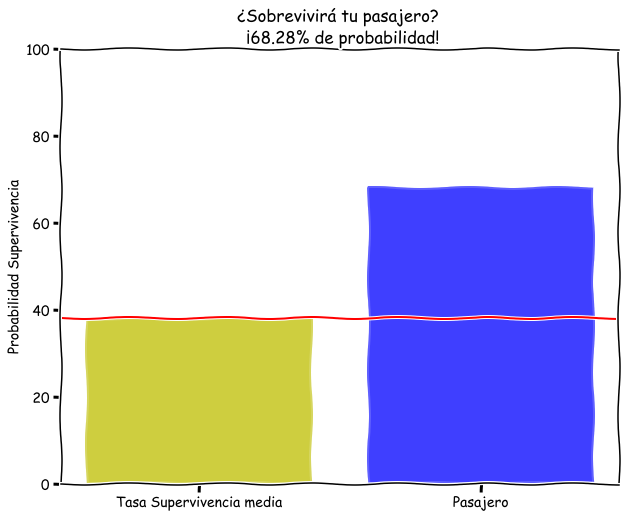

In [66]:
with plt.xkcd():
    plt.figure(figsize=(10,8))

    plt.bar(range(2),
            [tasa_media_super, y_prob[0][1]*100],
            align='center', 
            color=['y', 'b'], 
            alpha=0.5)

    plt.xticks(range(2), ['Tasa Supervivencia media', 'Pasajero'])

    plt.axhline(tasa_media_super, color='r')
    plt.ylim([0,100])
    plt.ylabel('Probabilidad Supervivencia')
    plt.title('¿Sobrevivirá tu pasajero? \n '+'¡{:.2f}% de probabilidad!'.format(y_prob[0][1]*100))

    plt.show();

# Preparando Data para Produccion


In [70]:
def data():
    
    df=pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')
    
    df.cabin=df.cabin.replace(np.NaN, 'U') 
    df.cabin=[e[0] for e in df.cabin.values]
    df.cabin=df.cabin.replace('U', 'Unknown')
    
    df['title']=[e.split()[1] for e in df.name.values]
    df.title=[t if t in ['Mr.', 'Miss.', 
                         'Mrs.', 'Master.', 
                         'Dr.', 'Rev.'] else 'Unknown'
              for t in df.title.values ]
    
    df['isfemale']=np.where(df.sex=='female', 1, 0)
    
    df=df[[f for f in list(df) if f not in ['sex', 
                                            'name', 
                                            'boat',
                                            'body', 
                                            'ticket', 
                                            'home.dest']]]

    df.pclass=np.where(df.pclass== 1,'First', 
                       np.where(df.pclass==2, 
                                'Second', 'Third'))

    df.embarked=df.embarked.replace(np.NaN, 'Unknown')
    
    df_dummy=pd.get_dummies(df, 
                            columns=['pclass', 'cabin', 
                                     'embarked', 'title'], 
                            drop_first=True, 
                            dummy_na=True)
    
    df_dummy=df_dummy.dropna()
    
    df_dummy.to_csv('data/titanic.csv', header=False, index=False)

    
    
    
data()  # se guarda el df sin nombres de columnas ni indice

# Web-App (main.py)

In [ ]:
from flask import Flask
from flask import render_template
from flask import flash
from flask import request
from flask import jsonify
from flask import Markup

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import io, base64, os

import numpy as np
from numpy import genfromtxt
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.model_selection import train_test_split as tts
 

    
# default inicial
EMBARKED='Southampton'
FARE=33
AGE=30
GENDER='Female'
TITLE='Mrs.'
CLASS='Second'
CABIN='C'
SIBSP=0
PARCH=0


# inicializando variables
tasa_media=0



# modelo 
logreg=LogReg()



# flask app
app=Flask(__name__)



# antes del primer request...
@app.before_first_request
def startup():
    global tasa_media, logreg
    
    data=genfromtxt('data/titanic.csv', delimiter=',')
    
    tasa_media=(np.mean([e[0] for e in data])*100)

    X_train, X_test, y_train, y_test=tts([e[1:] for e in data], 
                                         [e[0] for e in data], 
                                         test_size=0.1, 
                                         random_state=42)
    
    logreg.fit(X_train, y_train)  # se entrena una vez antes de arrancar
    
    

    
# main app
@app.route("/", methods=['POST', 'GET'])
def main():
    model_results=''
    
    if request.method=='POST':
        s_embarked=request.form['s_embarked']
        s_fare=request.form['s_fare']
        s_age=request.form['s_age']
        s_gender=request.form['s_gender']
        s_title=request.form['s_title']
        s_class=request.form['s_class']
        s_cabin=request.form['s_cabin']
        s_sibsp=request.form['s_sibsp']
        s_parch=request.form['s_parch']
        
        # se reasigna para prediccion
        age=int(s_age)
        isfemale=1 if s_gender=='Female' else 0
        sibsp=int(s_sibsp)
        parch=int(s_parch)
        fare=int(s_fare)
        
        
        # puerto de embarque
        embarked_Q=1
        embarked_S=0
        embarked_Unknown=0 
        embarked_nan=0
        if (s_embarked[0]=='Q'):
            embarked_Q = 1
        if (s_embarked[0]=='S'):
            embarked_S = 1
            
        
        # clase
        pclass_Second=0
        pclass_Third=0
        pclass_nan=0
        if (s_class=='Second'):
            pclass_Second=0
        if (s_class=='Third'):
            pclass_Third=0
            
            
        
        # titulo
        title_Master=0
        title_Miss=0
        title_Mr=0
        title_Mrs=0
        title_Rev=0
        title_Unknown=0
        title_nan=0
        if (s_title=='Master.'):
            title_Master=1
        if (s_title=='Miss.'):
            title_Miss=1
        if (s_title=='Mr.'):
            title_Mr=1
        if (s_title=='Mrs.'):
            title_Mrs=1
        if (s_title=='Rev.'):
            title_Master=1
        if (s_title=='Unknown'):
            title_Unknown=1
            
            
        
        # pasajero
        pasajero=[[age, sibsp, parch, fare, isfemale, 
                   pclass_Second, pclass_Third, pclass_nan, 
                   cabin_B, cabin_C, cabin_D, cabin_E, cabin_F, cabin_G,
                   cabin_T, cabin_Unknown, cabin_nan, embarked_Q, 
                   embarked_S, embarked_Unknown, embarked_nan, 
                   title_Master, title_Miss, title_Mr, title_Mrs, 
                   title_Rev, title_Unknown, title_nan]]
        
        
        # prediccion
        y_prob=logreg.predict_proba(pasajero)
        
        prob_super=y_prob[0][1]*100
        
        
        # plot
        with plt.xkcd():
            plt.figure()
            plt.bar(range(2),[tasa_media, y_prob[0][1]*100],
                    align='center', color=['y', 'b'], alpha=0.5)
            
            plt.xticks(range(2), ['Tasa Supervivencia media', 'Pasajero'])
            plt.axhline(tasa_media_super, color='r')
            plt.ylim([0,100])
            plt.ylabel('Probabilidad Supervivencia')
            plt.title('¿Sobrevivirá tu pasajero? \n '+'¡{:.2f}% de probabilidad!'.format(y_prob[0][1]*100))
            img=io.BytesIO()
            plt.savefig(img, format='png')
            img.seek(0)
            plot_url=base64.b64encode(img.getvalue()).decode()
            
        
        return render_template('index.html',
            model_results=model_results,
            model_plot=Markup('<img src="data:image/png;base64,{}">'.format(plot_url)),
            selected_embarked=s_embarked,
            selected_fare=s_fare,
            selected_age=s_age,
            selected_gender=s_gender,
            selected_title=s_title,
            selected_class=s_class,
            selected_cabin=s_cabin,
            selected_sibsp=s_sibsp,
            selected_parch=s_parch)
    
    else:
        # parametros por defecto
        return render_template('index.html',
            model_results = '',
            model_plot = '',
            selected_embarked=EMBARKED,
            selected_fare=FARE,
            selected_age=AGE,
            selected_gender=GENDER,
            selected_title=TITLE,
            selected_class=CLASS,
            selected_cabin=CABIN,
            selected_sibsp=SIBSP,
            selected_parch=PARCH)

if __name__=='__main__':
	app.run(debug=False)
    
    
    
    
    